In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path("./data")
fer2013 = pd.read_csv(data_dir / "fer2013.csv")
fer_plus = pd.read_csv(data_dir / "fer2013new.csv")
fer2013 = fer2013.drop(columns=["emotion"])
fer_plus = fer_plus.drop(columns=["Image name"])

In [ ]:
CLASS_LABELS = [
    "neutral",
    "happiness",
    "surprise",
    "sadness",
    "anger",
    "disgust",
    "fear",
    "contempt",
    "unknown",
    "NF",
]

data = pd.concat([fer2013, fer_plus[CLASS_LABELS]], axis=1)

for c in data[CLASS_LABELS]:
    data[c] = pd.to_numeric(data[c], errors="coerce")
print(f"NaN values: \n{data[CLASS_LABELS].isna().sum()}")

NaN values: 
neutral      0
happiness    0
surprise     0
sadness      0
anger        0
disgust      0
fear         0
contempt     0
unknown      0
NF           0
dtype: int64


In [3]:
label_counts = data[CLASS_LABELS].idxmax(axis=1).value_counts()
print(label_counts)

neutral      12906
happiness     9355
surprise      4462
sadness       4371
anger         3111
fear           819
disgust        248
unknown        222
contempt       216
NF             177
Name: count, dtype: int64


In [4]:
mean_distribution = data[CLASS_LABELS].mean(axis=0)
mean_distribution /= mean_distribution.sum()
print(mean_distribution.round(2))

neutral      0.30
happiness    0.25
surprise     0.12
sadness      0.13
anger        0.08
disgust      0.02
fear         0.03
contempt     0.02
unknown      0.05
NF           0.01
dtype: float64


Conclusion: heavy class imbalance

Rows with faces: 35538
Rows without faces: 349


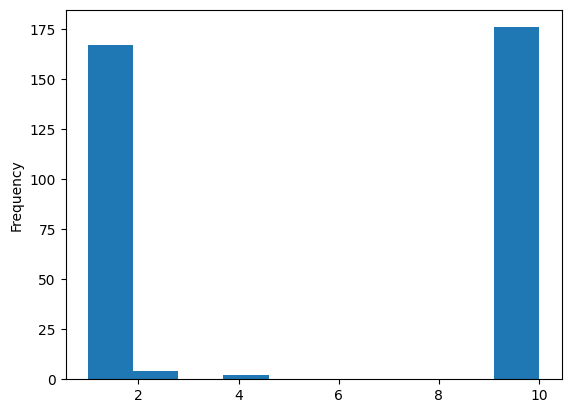

In [5]:
import numpy as np

print(f"Rows with faces: {len(data[data['NF'] == 0])}")
print(f"Rows without faces: {len(data[data['NF'] > 0])}")
data[data["NF"] > 0]["NF"].plot.hist();

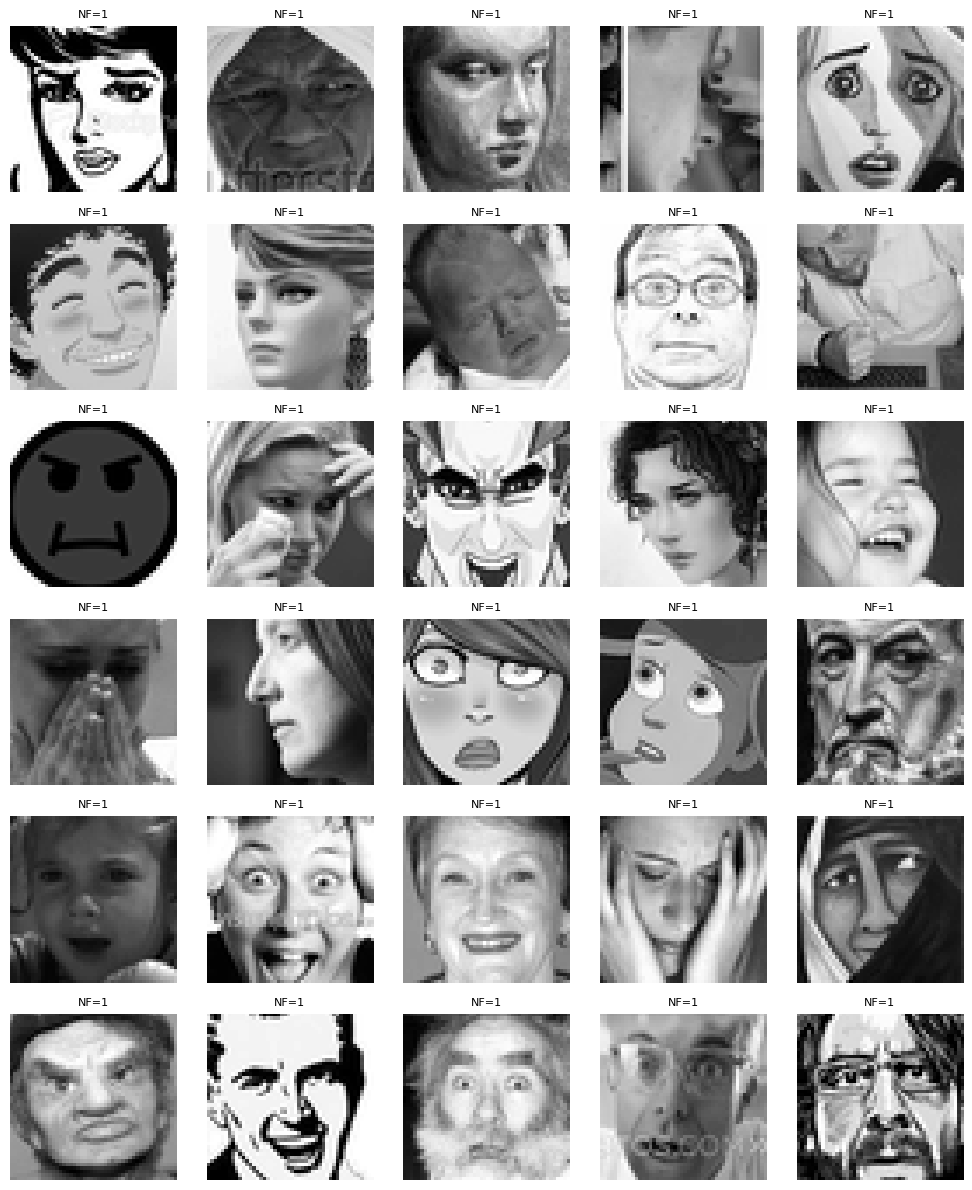

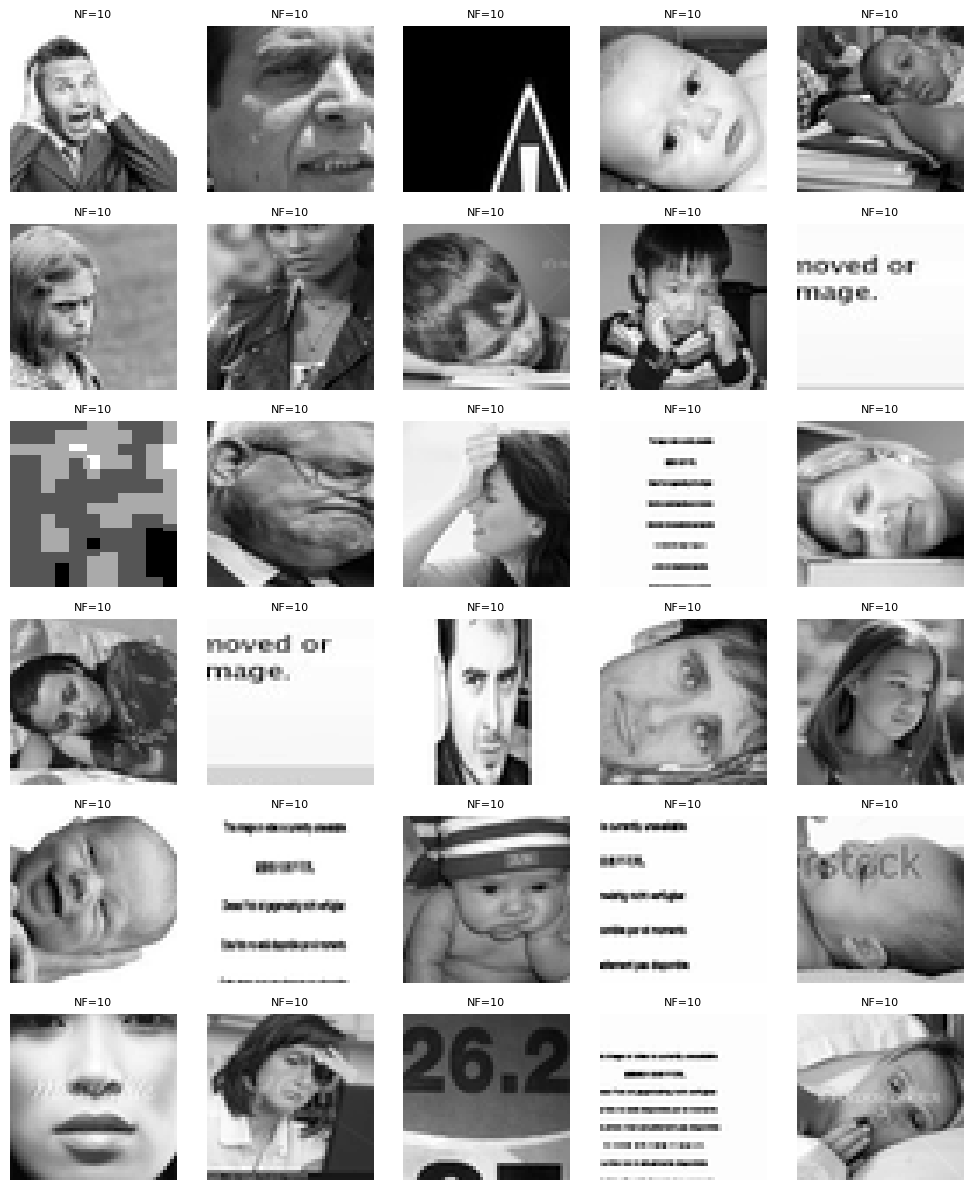

In [6]:
import matplotlib.pyplot as plt


def decode_image(pixel_str):
    pixels = np.array([int(p) for p in pixel_str.split()], dtype=np.uint8)
    return pixels.reshape(48, 48)


np_images = {idx: decode_image(row["pixels"]) for idx, row in data.iterrows()}


def show_images(nf_threshold):
    filtered_indices = data[data["NF"] == nf_threshold].index[:30]
    n_images = len(filtered_indices)

    if n_images == 0:
        print(f"No images with NF >= {nf_threshold}")
        return

    cols = 5
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
    axes = axes.flatten() if n_images > 1 else [axes]

    for plot_idx, data_idx in enumerate(filtered_indices):
        img = np_images[data_idx]
        axes[plot_idx].imshow(img, cmap="gray")
        axes[plot_idx].set_title(f"NF={data.loc[data_idx, 'NF']}", fontsize=8)
        axes[plot_idx].axis("off")

    for idx in range(n_images, len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


show_images(1)
show_images(10)

Conclusion: images with NF=1 contain faces but NF=10 mostly don't; removing images NF=10 from dataset

In [ ]:
data = data[data["NF"] < 10]

Exploring brightness in search of empty images

In [8]:
brightness = []
for str_px in data["pixels"]:
    np_img = decode_image(str_px)
    brightness.append(np_img.mean())
brightness = np.array(brightness)

In [9]:
f"min brighness: {brightness.min():.1f}, max brightness: {brightness.max():.1f}"

'min brighness: 8.6, max brightness: 235.3'

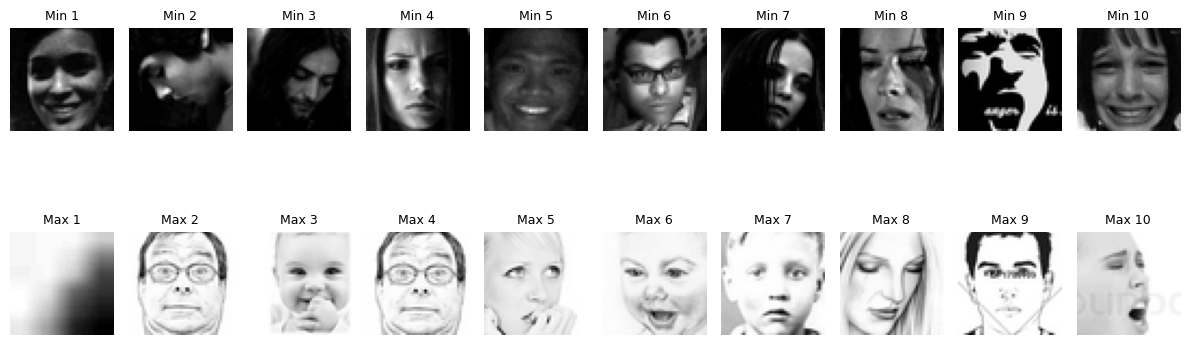

In [10]:
brightness_sorted_idx = brightness.argsort()

fig, axes = plt.subplots(2, 10, figsize=(12, 5))

for i in range(10):
    axes[0, i].imshow(
        decode_image(data.iloc[brightness_sorted_idx[i]]["pixels"]), cmap="gray"
    )
    axes[0, i].set_title(f"Min {i + 1}", fontsize=9)
    axes[0, i].axis("off")

    axes[1, i].imshow(
        decode_image(data.iloc[brightness_sorted_idx[-(i + 1)]]["pixels"]), cmap="gray"
    )
    axes[1, i].set_title(f"Max {i + 1}", fontsize=9)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

1 non-face image; but I see that deduplication is needed

In [11]:
from imagededup.methods import PHash

phasher = PHash()
hashes = {
    str(key): phasher.encode_image(image_array=img) for key, img in np_images.items()
}

duplicates = phasher.find_duplicates(encoding_map=hashes, max_distance_threshold=2)
duplicates

/home/dawid/projects/inzynierka_169257/.venv/lib/python3.12/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-11-09 23:50:00,827: INFO Start: Evaluating hamming distances for getting duplicates
2025-11-09 23:50:00,827: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 35887/35887 [01:13<00:00, 488.52it/s]
2025-11-09 23:51:14,743: INFO End: Retrieving duplicates using Cython Brute force algorithm
2025-11-09 23:51:14,744: INFO End: Evaluating hamming distances for getting duplicates


{'0': [],
 '1': [],
 '2': [],
 '3': [],
 '4': [],
 '5': [],
 '6': [],
 '7': [],
 '8': [],
 '9': [],
 '10': [],
 '11': [],
 '12': [],
 '13': [],
 '14': [],
 '15': [],
 '16': [],
 '17': [],
 '18': [],
 '19': [],
 '20': [],
 '21': ['11338', '17646', '25594', '35683', '13152'],
 '22': [],
 '23': [],
 '24': [],
 '25': [],
 '26': [],
 '27': [],
 '28': [],
 '29': ['14890', '34844'],
 '30': ['19215'],
 '31': [],
 '32': [],
 '33': [],
 '34': [],
 '35': [],
 '36': [],
 '37': [],
 '38': ['26123'],
 '39': [],
 '40': [],
 '41': [],
 '42': [],
 '43': [],
 '44': [],
 '45': [],
 '46': [],
 '47': [],
 '48': [],
 '49': ['29880'],
 '50': ['6821'],
 '51': [],
 '52': [],
 '53': [],
 '54': [],
 '55': [],
 '56': [],
 '57': [],
 '58': ['18525', '26462'],
 '59': [],
 '60': [],
 '61': [],
 '62': ['24142'],
 '63': [],
 '64': [],
 '65': [],
 '66': [],
 '67': [],
 '68': [],
 '69': ['15056'],
 '70': ['16983'],
 '71': ['5406'],
 '72': [],
 '73': [],
 '74': [],
 '75': [],
 '76': [],
 '77': ['13920'],
 '78': ['32404']

In [ ]:
from collections import defaultdict, deque

keys_order = [str(k) for k in np_images.keys()]
rank = {k: i for i, k in enumerate(keys_order)}

graph = defaultdict(set)
for a, neighs in duplicates.items():
    for b in neighs:
        graph[a].add(b)
        graph[b].add(a)

seen = set()
dup_groups = []
for node in keys_order:
    if node in seen or node not in graph:
        continue
    comp = []
    q = deque([node])
    seen.add(node)
    while q:
        u = q.popleft()
        comp.append(u)
        for v in graph[u]:
            if v not in seen:
                seen.add(v)
                q.append(v)
    comp.sort(key=lambda k: rank.get(k, float("inf")))
    dup_groups.append(comp)


print(f"Original dataset size: {len(data)}")
print(f"Duplicate groups: {len(dup_groups)}")

indices_to_remove = {int(k) for comp in dup_groups for k in comp[1:]}
to_remove = set(indices_to_remove) & set(data.index)
data = data.drop(index=list(to_remove), columns=["NF"]).reset_index(drop=True)

print(f"Removed {len(indices_to_remove)} duplicate images")
print(f"After deduplication: {len(data)}")

data

Original dataset size: 35711
Duplicate groups: 1770
Removed 2316 duplicate images
After deduplication: 33407


,pixels,Usage,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,4,0,0,1,3,2,0,0,0
1,151 150 147 155 148 133 111 140 170 174 182 15...,Training,6,0,1,1,0,0,0,0,2
2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,5,0,0,3,1,0,0,0,1
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,4,0,0,4,1,0,0,0,1
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,9,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
33402,164 172 175 171 172 173 178 181 188 192 197 20...,PrivateTest,0,0,1,6,0,0,3,0,0
33403,181 177 176 156 178 144 136 132 122 107 131 16...,PrivateTest,5,0,0,3,0,0,0,0,2
33404,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest,8,0,0,2,0,0,0,0,0
33405,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest,0,0,0,0,7,1,0,2,0
